Import needed libraries and the dataset csv

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Build path to file
# Selects current working directory
cwd = Path.cwd()
csv_path = 'data/dataframe.csv'
csv_cleaned_path = 'data/dataframe_cleaned.csv'
src_path = (cwd / csv_path).resolve()
out_path = (cwd / csv_cleaned_path).resolve()

# Read the csv
csv = pd.read_csv(src_path, index_col=0)
csv.shape

(19980, 20)

Clean up the dataset

In [2]:
# Removing unneeded data
# dropping empty rows
csv = csv.dropna(how='all')
# dropping duplicates (if any)
csv = csv.drop_duplicates()
# Dropping house and appartment groups since they have no data
csv = csv.drop(csv[(csv['property_type'] == 'HOUSE_GROUP') | (csv['property_type'] == 'APARTMENT_GROUP')].index)
# Drop rows without a price property
csv = csv.drop(csv[pd.isna(csv['price']) == True].index)
# Drop rows with 0 rooms
csv = csv.drop(csv[csv['number_rooms'] == 0].index)
# Drop rows without a living area property
csv = csv.drop(csv[pd.isna(csv['living_area']) == True].index)
# Assuming that a NaN value or 0 means no kitchen installed, replacing the strings with integers
# 0 = NOT_INSTALLED, 0.5 = SEMI_EQUIPPED, 1 = INSTALLED, 2 = HYPER_EQUIPPED
csv['kitchen'] = csv['kitchen'].fillna(0)
csv['kitchen'] = csv['kitchen'].replace('0', 0)
csv['kitchen'] = csv['kitchen'].replace('NOT_INSTALLED', 0)
csv['kitchen'] = csv['kitchen'].replace('USA_UNINSTALLED', 0)
csv['kitchen'] = csv['kitchen'].replace('SEMI_EQUIPPED', 0.5)
csv['kitchen'] = csv['kitchen'].replace('USA_SEMI_EQUIPPED', 0.5)
csv['kitchen'] = csv['kitchen'].replace('INSTALLED', 1)
csv['kitchen'] = csv['kitchen'].replace('USA_INSTALLED', 1)
csv['kitchen'] = csv['kitchen'].replace('HYPER_EQUIPPED', 2)
csv['kitchen'] = csv['kitchen'].replace('USA_HYPER_EQUIPPED', 2)
# Filling empty values and changing true/false to 1/0
csv['furnished'] = csv['furnished'].fillna(0)
csv['furnished'] = csv['furnished'].replace(False, 0)
csv['furnished'] = csv['furnished'].replace(True, 1)
# Assuming that a NaN value,0 or -1 means no fireplace installed
csv['fireplace'] = csv['fireplace'].fillna(0)
csv['fireplace'] = csv['fireplace'].replace(-1, 0)
# Filling empty values and changing true/false to 1/0
csv['terrace'] = csv['terrace'].fillna(0)
csv['terrace'] = csv['terrace'].replace(False, 0)
csv['terrace'] = csv['terrace'].replace(True, 1)
# Assuming the surface area = living area in case of apartments
to_replace = csv[((csv['surface_land'] == 'UNKNOWN')|(pd.isna(csv['surface_land']) == True)) & (csv['property_type'] == 'APARTMENT')]
to_replace = to_replace.reset_index()
# Looping through rows to replace the values
for index, row in to_replace.iterrows():
    csv.loc[row['index'], 'surface_land'] = row['living_area']
# Dropping rows with no surface area 
csv = csv.drop(csv[(csv['surface_land'] == 'UNKNOWN') | (pd.isna(csv['surface_land']) == True)].index)
# Dropping rows with no facade info
csv = csv.drop(csv[(csv['number_facades'] == 'UNKNOWN') | (pd.isna(csv['number_facades']) == True)].index)
# Filling empty values and changing true/false to 1/0
csv['swimming_pool'] = csv['swimming_pool'].fillna(0)
csv['swimming_pool'] = csv['swimming_pool'].replace(False, 0)
csv['swimming_pool'] = csv['swimming_pool'].replace(True, 1)
csv = csv.drop(csv[(csv['building_state'] == 'UNKNOWN') | (pd.isna(csv['building_state']) == True)].index)


This codeblock will drop all rows if:

 - terrace = 1 but no terrace_area is present
 - garden = 1 but no garden_area is present

This drops a lot of rows but results in a cleaner dataset. 

You can opt to use the codeblock below instead to keep a bigger dataset.

In [3]:
# If terrace = 1 but no terrace_area present, drop the row
csv = csv.drop(csv[(csv['terrace'] == 1) & (pd.isna(csv['terrace_area']) == True)].index)
# Filling empty values and changing true/false to 1/0
csv['terrace_area'] = csv['terrace_area'].fillna(0)
# If garden = 1 but no garden_area present, drop the row
csv = csv.drop(csv[(csv['garden'] == 1) & (pd.isna(csv['garden_area']) == True)].index)
# No garden, filling empty values
csv['garden'] = csv['garden'].fillna(0)
csv['garden'] = csv['garden'].replace(False, 0)
csv['garden'] = csv['garden'].replace(True, 1)
csv['garden_area'] = csv['garden_area'].fillna(0)

This codeblock fills in missing values of garden_area and terrace_area with the mean value of identical property types

In [4]:

"""filter = csv[(csv['terrace'] == 1) & (pd.isna(csv['terrace_area']) == False)][['property_type', 'terrace_area']]
mean_calc = (filter.groupby('property_type')['terrace_area'].sum())/(filter.groupby('property_type')['terrace_area'].count())
# Loop through property types
for type in csv['property_type'].unique():
    try:
        csv['terrace_area'] = csv[(csv['terrace'] == 1) & (pd.isna(csv['terrace_area']) == True) & (csv['property_type'] == type)]['terrace_area'].replace(np.nan, mean_calc.loc[type])
    except: 
        pass
# No terrace, terrace_area = 0
csv['terrace_area'] = csv['terrace_area'].fillna(0)
# Filling empty values and changing true/false to 1/0
csv['garden'] = csv['garden'].fillna(0)
csv['garden'] = csv['garden'].replace(False, 0)
csv['garden'] = csv['garden'].replace(True, 1)
# If garden = 1 but no garden_area present, calculate the mean garden_area of property_type
filter = csv[(csv['garden'] == 1) & (pd.isna(csv['garden_area']) == False)][['property_type', 'garden_area']]
mean_calc = (filter.groupby('property_type')['garden_area'].sum())/(filter.groupby('property_type')['garden_area'].count())
# Loop through property types
for type in csv['property_type'].unique():
    try:
        csv['garden_area'] = csv[(csv['garden'] == 1) & (pd.isna(csv['garden_area']) == True) & (csv['property_type'] == type)]['garden_area'].replace(np.nan, mean_calc.loc[type])
    except: 
        pass
# No terrace, terrace_area = 0
csv['garden_area'] = csv['garden_area'].fillna(0)"""

"filter = csv[(csv['terrace'] == 1) & (pd.isna(csv['terrace_area']) == False)][['property_type', 'terrace_area']]\nmean_calc = (filter.groupby('property_type')['terrace_area'].sum())/(filter.groupby('property_type')['terrace_area'].count())\n# Loop through property types\nfor type in csv['property_type'].unique():\n    try:\n        csv['terrace_area'] = csv[(csv['terrace'] == 1) & (pd.isna(csv['terrace_area']) == True) & (csv['property_type'] == type)]['terrace_area'].replace(np.nan, mean_calc.loc[type])\n    except: \n        pass\n# No terrace, terrace_area = 0\ncsv['terrace_area'] = csv['terrace_area'].fillna(0)\n# Filling empty values and changing true/false to 1/0\ncsv['garden'] = csv['garden'].fillna(0)\ncsv['garden'] = csv['garden'].replace(False, 0)\ncsv['garden'] = csv['garden'].replace(True, 1)\n# If garden = 1 but no garden_area present, calculate the mean garden_area of property_type\nfilter = csv[(csv['garden'] == 1) & (pd.isna(csv['garden_area']) == False)][['property_ty

Save the cleaned up csv 

In [5]:
# Saves cleaned up csv to 'data/dataframe_cleaned.csv'
csv.to_csv(out_path)

Looks up the coordinates of the locality and does a reverse lookup to get the full adress information. 

(Not used, adapted scraper instead)

In [6]:
"""# Import the required library
from geopy.geocoders import Nominatim
class address ():

    def __init__(self, locality) -> None:

        # Initialize Nominatim API
        geolocator = Nominatim(user_agent="MyApp")
        location = geolocator.geocode(locality)

        # Latitude & Longitude input
        Latitude = str(location.latitude)
        Longitude = str(location.longitude)
    
        location = geolocator.reverse(Latitude + "," + Longitude)

        self.address = location.raw['address']
        self.city = self.address.get('city', '')
        self.state = self.address.get('state', '')
        self.zipcode = self.address.get('postcode')"""

'# Import the required library\nfrom geopy.geocoders import Nominatim\nclass address ():\n\n    def __init__(self, locality) -> None:\n\n        # Initialize Nominatim API\n        geolocator = Nominatim(user_agent="MyApp")\n        location = geolocator.geocode(locality)\n\n        # Latitude & Longitude input\n        Latitude = str(location.latitude)\n        Longitude = str(location.longitude)\n    \n        location = geolocator.reverse(Latitude + "," + Longitude)\n\n        self.address = location.raw[\'address\']\n        self.city = self.address.get(\'city\', \'\')\n        self.state = self.address.get(\'state\', \'\')\n        self.zipcode = self.address.get(\'postcode\')'

How many rows and colums? 

In [7]:
csv.shape

(6889, 20)

What is the correlation between the variables and the price? (Why might that be?)

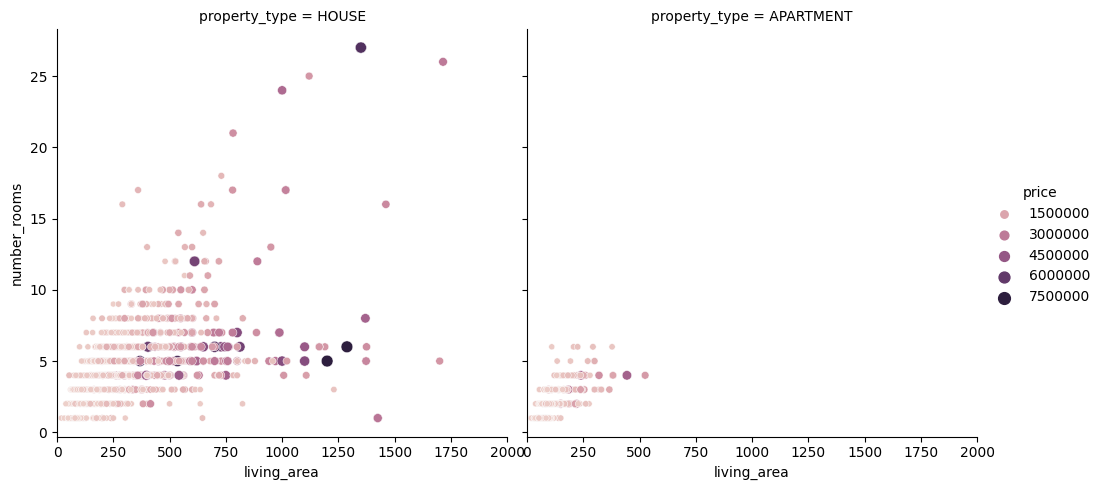

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.relplot(x = 'living_area', 
            y = 'number_rooms',
            data = csv,
            kind = 'scatter',
            col = 'property_type',
            size = 'price',
            hue = 'price'
            )
plt.xlim(0,2000)
plt.show()

We can see that while some of the more expensive houses have more rooms, living area seems to affect the price more. 

In the case of apartments we can see the same trend, except for one outlier. 

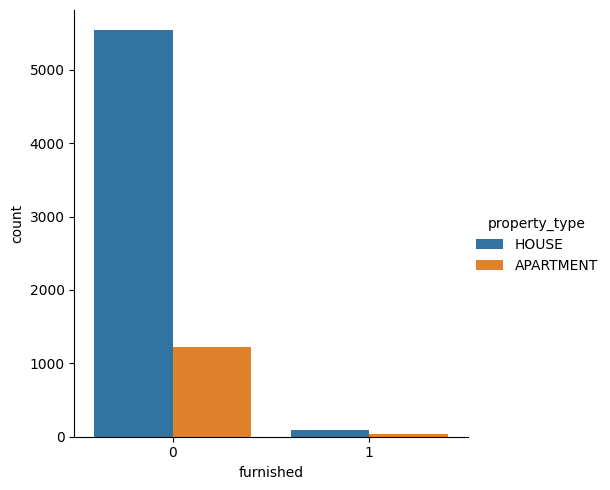

In [9]:
sns.catplot(x = 'furnished', 
            data = csv,
            kind = 'count',
            hue = 'property_type',
            )
plt.show()

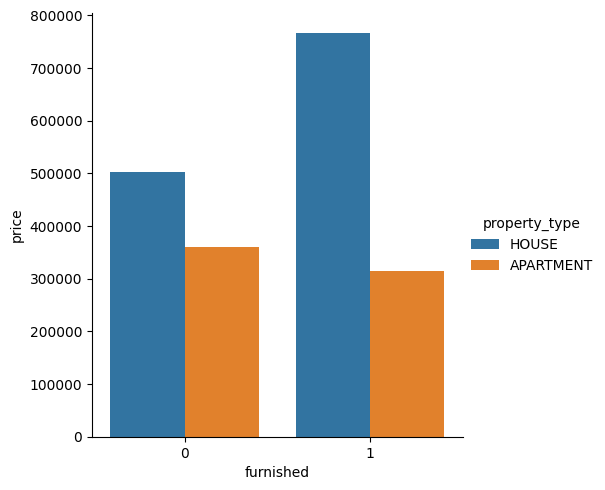

In [10]:
sns.catplot(x = 'furnished', 
            y = 'price',
            data = csv,
            kind = 'bar',
            hue = 'property_type',
            errorbar = None
            )
plt.show()

Only a negligable amount of properties being sold are furnished. 

Interesting to see is that for apartments, the average sale price is higher when the apartment is furnished, while the reverse is true for houses. 

We have to consider that the price difference can be related to different things however. 

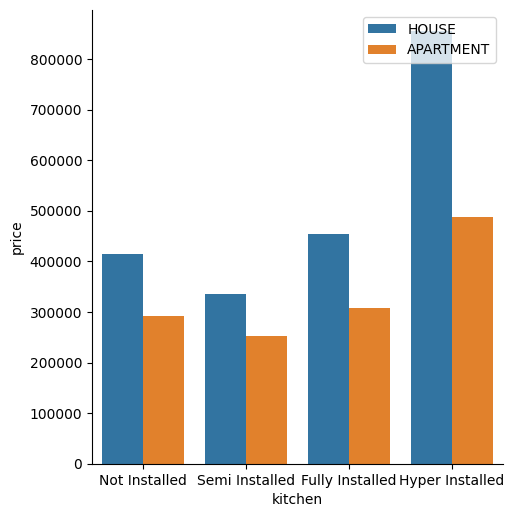

In [19]:
kitchen = sns.catplot(x = 'kitchen', 
                    y = 'price',
                    data = csv,
                    kind = 'bar',
                    hue = 'property_type',
                    errorbar = None,
                    legend=None
                    )
kitchen.set(xticklabels=["Not Installed", "Semi Installed", "Fully Installed", "Hyper Installed"])
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=1.0)
plt.legend(loc='upper right')
plt.show()

We can see that unless you have a hyper equipped kitchen, it does not affect the price very much.

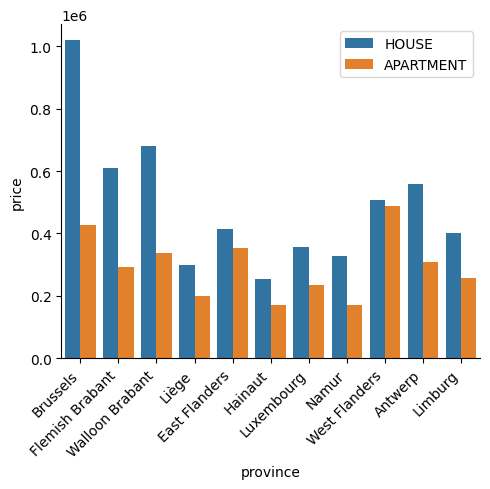

In [29]:
plot = sns.catplot(x = 'province', 
            y = 'price',
            data = csv,
            kind = 'bar',
            hue = 'property_type',
            errorbar = None,
            legend=None
            )
plt.xticks(rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()